### 在20180502_03LightGBM_addFeatures的基础上新增title、description等列的tf-idf特征

In [17]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from string import punctuation as en_punctuation
import re
from nltk.corpus import stopwords
# import graphviz
import os
from sklearn import preprocessing
from scipy.stats import pearsonr
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [64]:
current_dir = r'/home/yw/study/Competition/Avito-Demand-Prediction-Challenge'
data_dirs = dict()
data_dirs['train_data'] = os.path.join(current_dir, 'data/train.csv')
data_dirs['test_data'] = os.path.join(current_dir, 'data/test.csv')
data_dirs['periods_train'] = os.path.join(current_dir, 'data/periods_train.csv')
data_dirs['periods_test'] = os.path.join(current_dir, 'data/periods_test.csv')
data_dirs['train_active'] = os.path.join(current_dir, 'data/train_active.csv')
data_dirs['test_active'] = os.path.join(current_dir, 'data/test_active')
data_dirs['pred_result'] = os.path.join(current_dir, 'data/submits/20180503_04LightGBM_addTfIdfFeatures.csv')
data_dirs['model_path'] = os.path.join(current_dir, 'data/model_data/20180503_04LightGBM_addTfIdfFeatures.pkl')
data_dirs['train_feature_path'] = os.path.join(current_dir, 'data/features/20180503_04LightGBM_addTfIdfFeatures/train.csv')
data_dirs['test_feature_path'] = os.path.join(current_dir, 'data/features/20180503_04LightGBM_addTfIdfFeatures/test.csv')

### a 特征提取

In [3]:
def filter_text(text, filters=None, lower=True):
    """
    对文本进行过滤
    :param text: 需要过滤处理的文本
    :param filters: 需要过滤掉的字符集
    :param lower: 是否忽略英文字符的大小写
    :return: 过滤后的文本
    """
    if lower:
        text = text.lower()
    if filters is None:
        filters = en_punctuation+r'\t\r\n\f\v'
    sub_parttern = '['+filters+']'
    text = re.sub(sub_parttern, ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def load_text_data(data_path, train=False, text_columns=None):
    if text_columns is None:
        text_columns = ['title', 'description']
    column_len = len(text_columns)
    if train:
        texts = pd.read_csv(data_path, usecols=text_columns + ['deal_probability'])
        targets = texts['deal_probability'].values
        texts = texts[text_columns].apply(lambda x: ' '.join([('' if x[i] is np.nan else str(x[i])) for i in range(column_len)]), axis=1)
        texts = texts.apply(filter_text)
        return texts, targets
    else:
        texts = pd.read_csv(data_path, usecols=text_columns + ['item_id'])
        pred_items = texts[['item_id']]
        texts = texts[text_columns].apply(
            lambda x: ' '.join([('' if x[i] is np.nan else str(x[i])) for i in range(column_len)]), axis=1)
        texts = texts.apply(filter_text)
        return texts, pred_items

def get_tfidf(data_path, tfidf_transformer=None, train=False, text_columns=None):
    if text_columns is None:
        text_columns = ['title', 'description']
    print('get_tfidf:loading raw text data...')
    texts, targets = load_text_data(data_path, train=train, text_columns=text_columns)
    if train:
        print('get_tfidf:training TfidfVectorizer...')
        stop_words = list(stopwords.words('russian')) + list(stopwords.words('english'))
        tfidf_transformer = TfidfVectorizer(binary=False, norm='l2', stop_words=stop_words, max_features=200000)
        tfidf_transformer = tfidf_transformer.fit(texts)
    tfidf = tfidf_transformer.transform(texts)
    return tfidf, targets, tfidf_transformer

def word_count(raw_text):
    if type(raw_text) == float:
        return 0
    return len(raw_text.split()) 
    
def count_chars(raw_text):
    if type(raw_text) == float:
        return 0
    return len(raw_text)

def prepare_data(data_dirs):
    train_df = pd.read_csv(data_dirs['train_data'], parse_dates=["activation_date"])
    test_df = pd.read_csv(data_dirs['test_data'], parse_dates=["activation_date"])
    
    use_features = set()

    train_y = train_df["deal_probability"].values
    test_id = test_df["item_id"].values
    # explore features
    # [1]weekday
    train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
    test_df["activation_weekday"] = test_df["activation_date"].dt.weekday
    # [2]monthday
    train_df["activation_monthday"] = train_df["activation_date"].dt.day
    test_df["activation_monthday"] = test_df["activation_date"].dt.day
    # [3]hour
    train_df['activation_hour'] = train_df["activation_date"].dt.hour
    test_df['activation_hour'] = test_df["activation_date"].dt.hour
    
    use_features.update(['activation_weekday','activation_monthday','activation_hour'])
    
    text_columns=['param_1','param_2','param_3','title','description']+['parent_category_name','category_name']
    for feat_name in text_columns:
        # [4]char length
        feat_len = feat_name+"_len"
        train_df[feat_len] = train_df[feat_name].apply(count_chars)
        test_df[feat_len] = test_df[feat_name].apply(count_chars)
        # [5]word count
        feat_w_count = feat_name+"_w_count"
        train_df[feat_w_count] = train_df[feat_name].apply(word_count)
        test_df[feat_w_count] = test_df[feat_name].apply(word_count)
        
        use_features.update([feat_len, feat_w_count])
    
    # [6]images length
    train_df['image_exists'] = train_df['image'].isnull().astype(int)
    test_df['image_exists'] = test_df['image'].isnull().astype(int)
    
    use_features.add('image_exists')
    
    
    # [7]Label encode the categorical variables #
    cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
    for col in cat_vars:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
    use_features.update(cat_vars)
    
    use_features.update(['price', 'item_seq_number', 'image_top_1'])
    use_features=list(use_features)
    train_X = train_df[use_features]
    test_X = test_df[use_features]
    return train_X, train_y, test_X, test_id, cat_vars+['activation_weekday','activation_monthday','activation_hour']

In [4]:
def get_svd_feature(data_dirs, text_columns, n_comp=10):
    print('[1] Converting train texts to TF-IDF vectors...')
    x_train_tfidf, targets, tfidf_transformer = get_tfidf(data_dirs['train_data'],
                                                          tfidf_transformer=None,
                                                          train=True,
                                                          text_columns=text_columns)
    print('[2] Converting test texts to TF-IDF vectors...')
    x_test_tfidf, _, _ = get_tfidf(data_dirs['test_data'],
                                   tfidf_transformer=tfidf_transformer,
                                   train=False,
                                   text_columns=text_columns)
    print('[3] Training SVD transoformer...')
    trunc_svd = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    trunc_svd.fit(x_train_tfidf)
    print('[4] Decomposition...')
    train_svd = pd.DataFrame(trunc_svd.transform(x_train_tfidf))
    test_svd = pd.DataFrame(trunc_svd.transform(x_test_tfidf))
    train_svd.columns = ['svd_'+str(i+1) for i in range(n_comp)]
    test_svd.columns = ['svd_'+str(i+1) for i in range(n_comp)]
    
    return train_svd, test_svd

In [5]:
def combine_all_feature(data_dirs):
    text_columns = ['title', 'description']+['param_1', 'param_2', 'param_3', 'parent_category_name', 'category_name']
    n_comp = 10
    train_svd, test_svd = get_svd_feature(data_dirs, text_columns=text_columns, n_comp=n_comp)
    
    train_X, train_y, test_X, test_id, cat_vars= prepare_data(data_dirs)
    
    train_X = pd.concat([train_X, train_svd], axis=1)
    test_X = pd.concat([test_X, test_svd], axis=1)
    return train_X, train_y, test_X, test_id, cat_vars

In [6]:
train_X, train_y, test_X, test_id, cat_vars= combine_all_feature(data_dirs)

[1] Converting train texts to TF-IDF vectors...
get_tfidf:loading raw text data...
get_tfidf:training TfidfVectorizer...
[2] Converting test texts to TF-IDF vectors...
get_tfidf:loading raw text data...
[3] Training SVD transoformer...
[4] Decomposition...


In [9]:
train_X.head(3)

,param_2_w_count,param_3_w_count,title_w_count,category_name_len,param_2,param_1,user_type,parent_category_name_w_count,image_exists,activation_monthday,...,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10
0,0,0,3,26,112,249,1,2,0,28,...,0.041671,-0.040757,0.050099,0.178052,0.011905,-0.061201,-0.011576,0.028543,0.005648,-0.013546
1,0,0,3,17,112,122,1,4,0,26,...,0.011289,-0.028031,0.090803,0.014687,0.003909,0.157237,-0.114391,0.000993,-0.000381,-0.025389
2,0,0,2,13,112,84,1,2,0,20,...,0.016017,-0.020259,0.056241,0.034212,-0.002227,0.080857,0.149096,-0.026116,-0.004038,-0.011544


In [25]:
#train_X.to_csv(data_dirs['train_feature_path'],index=False)
#test_X.to_csv(data_dirs['test_feature_path'],index=False)

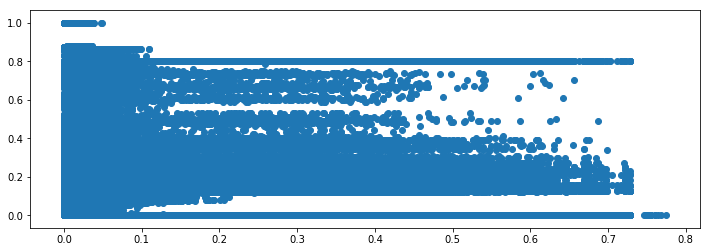

In [10]:
plt.scatter(train_X['svd_1'],train_y)

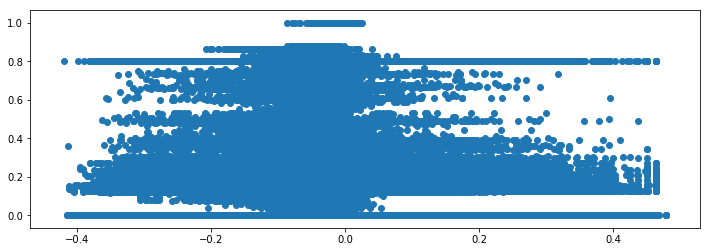

In [11]:
plt.scatter(train_X['svd_2'],train_y)

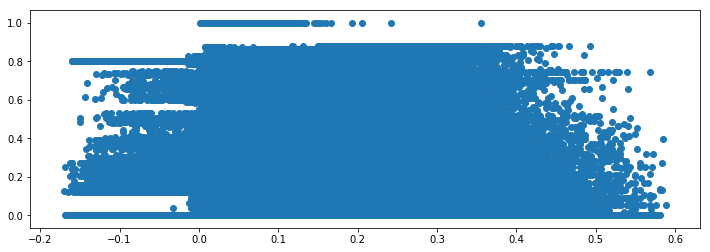

In [16]:
plt.scatter(train_X['svd_3'],train_y)

In [26]:
X_train,X_val,y_train,y_val=train_test_split(train_X,train_y,test_size=0.20,random_state=9)

# 1 Base line

In [27]:
def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=5000,folds=folds,nfold=cv_folds,stratified=False,
                        metrics='rmse',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['rmse-mean']))
        print('Best Iteration:',len(cvresult['rmse-mean']))
        
    alg.fit(X,y,eval_metric='rmse',feature_name=feature_names,categorical_feature=cat_features,
            eval_set=[(X,y),(X_test, y_test)],eval_names=['train','val'],verbose=20)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y,dtrain_predictions))))
    print('Model report on test:')
    print('Test RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test,dtest_predictions))))
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='gain')
    lgb.plot_metric(lgbr)
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='rmse',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='rmse',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

In [28]:
params={'boosting_type': 'gbdt',
        'colsample_bytree': 0.8,
       'learning_rate': 0.2,
       'max_bin': 168,
       'max_depth': 9,
       'min_child_samples': 30,
       'min_child_weight': 5,
       'min_split_gain': 1,
       'n_estimators': 200,
       'n_jobs': -1,
       'num_leaves': 60,
       'objective': 'regression',
       'random_state': 9,
       'reg_alpha': 0,
       'reg_lambda': 0,
       'subsample': 0.9,
       'subsample_freq': 1
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':60,
        'max_depth':9,
        'learning_rate':0.2,
        'max_bin':168,
        'objective':'regression',
        'min_gain_to_split':1,
        'min_sum_hessian_in_leaf':5,
        'min_data_in_leaf':1,
        'bagging_fraction':0.9,
        'bagging_freq':1,
        'feature_fraction':0.8,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':-1,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [29]:
lgbr=lgb.LGBMRegressor(**params)

[20]	cv_agg's rmse: 0.228778 + 0.00027885
[40]	cv_agg's rmse: 0.22783 + 0.000312128
[60]	cv_agg's rmse: 0.227629 + 0.000314154
[80]	cv_agg's rmse: 0.227629 + 0.000314371
Best Iteration: 61


/usr/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1004: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['activation_hour', 'activation_monthday', 'activation_weekday', 'category_name', 'city', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	train's rmse: 0.225771	val's rmse: 0.229078
[40]	train's rmse: 0.222517	val's rmse: 0.227759
[60]	train's rmse: 0.221867	val's rmse: 0.227646
Model report on trian:
Train RMSE:0.2219
Model report on test:
Test RMSE:0.2276


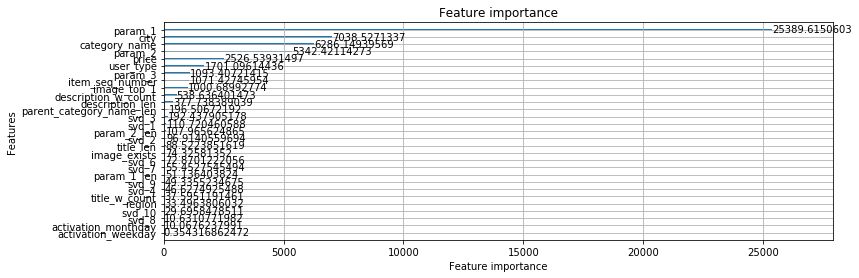

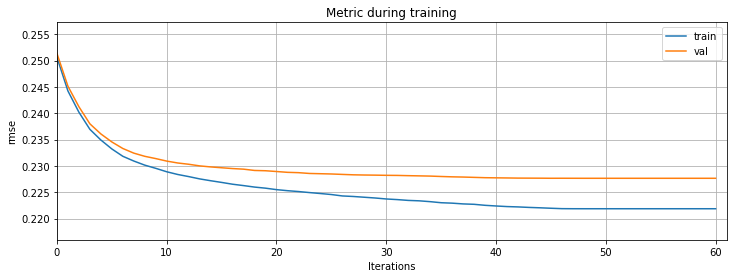

In [30]:
get_lgb_params(lgbr.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [31]:
params['n_estimators']=61

# 2 Tune params

In [32]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

In [33]:
def rmse(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))
scorer = metrics.make_scorer(rmse, greater_is_better=False)

## 2.1 num_leaves

In [34]:
searchParam={'num_leaves':(145,149,150,151,155)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 149
Best score: -0.22767869069
     mean_test_score  mean_train_score  std_test_score  std_train_score
145        -0.227696         -0.219586        0.000776         0.000171
149        -0.227679         -0.219481        0.000818         0.000356
150        -0.227690         -0.219490        0.000774         0.000205
151        -0.227681         -0.219591        0.000774         0.000176
155        -0.227746         -0.219516        0.000811         0.000118


## 2.2 max_depth

In [36]:
searchParam={'max_depth':[10,15,20,25,28]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 20
Best score: -0.227557785467
    mean_test_score  mean_train_score  std_test_score  std_train_score
10        -0.227591         -0.219189        0.000757         0.000293
15        -0.227601         -0.219201        0.000757         0.000118
20        -0.227558         -0.219143        0.000806         0.000248
25        -0.227558         -0.219143        0.000806         0.000248
28        -0.227558         -0.219143        0.000806         0.000248


In [37]:
searchParam={'max_depth':[5,13,17,20]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 17
Best score: -0.227503815257
    mean_test_score  mean_train_score  std_test_score  std_train_score
5         -0.228450         -0.224023        0.000834         0.000151
13        -0.227593         -0.219212        0.000858         0.000134
17        -0.227504         -0.219099        0.000802         0.000183
20        -0.227558         -0.219143        0.000806         0.000248


In [38]:
searchParam={'max_depth':[14,15,16,17,18]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 17
Best score: -0.227503815257
    mean_test_score  mean_train_score  std_test_score  std_train_score
14        -0.227610         -0.219277        0.000816         0.000399
15        -0.227601         -0.219201        0.000757         0.000118
16        -0.227606         -0.219084        0.000752         0.000252
17        -0.227504         -0.219099        0.000802         0.000183
18        -0.227545         -0.219132        0.000848         0.000133


## 2.3 subsample

In [48]:
#start

In [41]:
searchParam={'subsample':np.arange(0.7,1.0,0.01)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 1.0
Best score: -0.227372590754
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.70        -0.227844         -0.219903        0.000769         0.000208
0.71        -0.227852         -0.219780        0.000800         0.000212
0.72        -0.227886         -0.219764        0.000763         0.000123
0.73        -0.227838         -0.219733        0.000773         0.000270
0.74        -0.227792         -0.219556        0.000748         0.000341
0.75        -0.227818         -0.219558        0.000786         0.000358
0.76        -0.227747         -0.219442        0.000774         0.000194
0.77        -0.227675         -0.219394        0.000712         0.000147
0.78        -0.227697         -0.219251        0.000770         0.000391
0.79        -0.227661         -0.219288        0.000815         0.000253
0.80        -0.227646         -0.219205        0.000746         0.000313
0.81        -0.227571         -0.219126        0.000736         0.0

## 2.4 subsample_freq

In [42]:
searchParam={'subsample_freq':[1,2,3,4,5,6,7,8]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample_freq : 1
Best score: -0.227372590754
   mean_test_score  mean_train_score  std_test_score  std_train_score
1        -0.227373         -0.219695        0.000746         0.000237
2        -0.227373         -0.219695        0.000746         0.000237
3        -0.227373         -0.219695        0.000746         0.000237
4        -0.227373         -0.219695        0.000746         0.000237
5        -0.227373         -0.219695        0.000746         0.000237
6        -0.227373         -0.219695        0.000746         0.000237
7        -0.227373         -0.219695        0.000746         0.000237
8        -0.227373         -0.219695        0.000746         0.000237


## 2.5 colsample_bytree

In [43]:
searchParam={'colsample_bytree':[0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.6
Best score: -0.227156026285
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.60        -0.227156         -0.221530        0.000738         0.000282
0.70        -0.227219         -0.220546        0.000780         0.000101
0.75        -0.227367         -0.220169        0.000758         0.000290
0.80        -0.227373         -0.219695        0.000746         0.000237
0.85        -0.227424         -0.219576        0.000740         0.000134
0.90        -0.227548         -0.219248        0.000747         0.000194
0.95        -0.227584         -0.218636        0.000763         0.000251
1.00        -0.227718         -0.218377        0.000742         0.000209


In [50]:
searchParam={'colsample_bytree':[0.4,0.45,0.5,0.55,0.6,0.65]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.45
Best score: -0.226961046089
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.40        -0.227142         -0.222232        0.000766         0.000232
0.45        -0.226961         -0.222945        0.000796         0.000197
0.50        -0.227331         -0.221412        0.000777         0.000182
0.55        -0.227252         -0.221701        0.000821         0.000131
0.60        -0.227099         -0.221463        0.000769         0.000300
0.65        -0.227152         -0.220759        0.000820         0.000199


## 2.6 reg_alpha

In [44]:
searchParam={'reg_alpha':[0,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1,0.5,1,3,5,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_alpha : 0.01
Best score: -0.227098545333
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         -0.227156         -0.221530        0.000738         0.000282
0.00001         -0.227156         -0.221530        0.000738         0.000282
0.00005         -0.227156         -0.221530        0.000738         0.000282
0.00010         -0.227156         -0.221530        0.000738         0.000282
0.00050         -0.227135         -0.221559        0.000738         0.000246
0.00100         -0.227136         -0.221572        0.000791         0.000168
0.00500         -0.227147         -0.221529        0.000751         0.000257
0.01000         -0.227099         -0.221463        0.000769         0.000300
0.05000         -0.227121         -0.221455        0.000759         0.000235
0.10000         -0.227150         -0.221551        0.000722         0.000276
0.50000         -0.227117         -0.221496        0.000766         0.000131
1.00000         -0

In [51]:
searchParam={'reg_alpha':[0.008,0.009,0.01,0.015,0.02,0.03]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_alpha : 0.01
Best score: -0.226961046089
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.008        -0.227014         -0.222953        0.000821         0.000189
0.009        -0.226994         -0.222963        0.000807         0.000224
0.010        -0.226961         -0.222945        0.000796         0.000197
0.015        -0.227060         -0.223005        0.000792         0.000199
0.020        -0.227009         -0.223007        0.000766         0.000224
0.030        -0.227082         -0.223036        0.000814         0.000144


## 2.7 reg_lambda

In [45]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,0.9,1,1.1,1.5,2,5]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_lambda : 0.001
Best score: -0.227098545068
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000        -0.227099         -0.221463        0.000769         0.000300
0.00001        -0.227099         -0.221463        0.000769         0.000300
0.00100        -0.227099         -0.221463        0.000769         0.000300
0.10000        -0.227141         -0.221463        0.000836         0.000214
0.50000        -0.227137         -0.221550        0.000784         0.000260
0.90000        -0.227167         -0.221535        0.000767         0.000148
1.00000        -0.227161         -0.221490        0.000770         0.000237
1.10000        -0.227170         -0.221511        0.000783         0.000196
1.50000        -0.227126         -0.221537        0.000842         0.000157
2.00000        -0.227113         -0.221583        0.000762         0.000226
5.00000        -0.227140         -0.221579        0.000791         0.000246


## 2.8 min_child_samples

In [46]:
searchParam={'min_child_samples':[15,19,20,30,40,50,70,100]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 30
Best score: -0.227098545068
     mean_test_score  mean_train_score  std_test_score  std_train_score
15         -0.227167         -0.221488        0.000765         0.000211
19         -0.227183         -0.221440        0.000784         0.000274
20         -0.227145         -0.221541        0.000787         0.000264
30         -0.227099         -0.221463        0.000769         0.000300
40         -0.227182         -0.221525        0.000798         0.000193
50         -0.227158         -0.221555        0.000796         0.000224
70         -0.227108         -0.221481        0.000775         0.000240
100        -0.227125         -0.221596        0.000731         0.000265


## 2.9 min_child_weight

In [52]:
searchParam={'min_child_weight':[1e-5,2e-5,3e-5,5e-5,1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_weight : 1e-05
Best score: -0.226961046089
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00001        -0.226961         -0.222945        0.000796         0.000197
0.00002        -0.226961         -0.222945        0.000796         0.000197
0.00003        -0.226961         -0.222945        0.000796         0.000197
0.00005        -0.226961         -0.222945        0.000796         0.000197
0.00010        -0.226961         -0.222945        0.000796         0.000197
0.00050        -0.226961         -0.222945        0.000796         0.000197
0.00100        -0.226961         -0.222945        0.000796         0.000197
0.00500        -0.226961         -0.222945        0.000796         0.000197
0.01000        -0.226961         -0.222945        0.000796         0.000197
0.05000        -0.226961         -0.222945        0.000796         0.000197
0.10000        -0.226961         -0.222945        0.000796         0.000197
0.50000        -0.2269

## 2.10 max_bin

In [53]:
searchParam={'max_bin':[31,63,127,168,255,511]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_bin : 511
Best score: -0.226836510879
     mean_test_score  mean_train_score  std_test_score  std_train_score
31         -0.227675         -0.223849        0.000760         0.000201
63         -0.227333         -0.223374        0.000773         0.000276
127        -0.227101         -0.223132        0.000710         0.000268
168        -0.226961         -0.222945        0.000796         0.000197
255        -0.226898         -0.222566        0.000772         0.000102
511        -0.226837         -0.222139        0.000720         0.000132


## 2.11 min_split_gain

In [54]:
searchParam={'min_split_gain':[1e-3,0.01,0.1,0.16,0.17,0.18,0.19,0.5,0.9,1,1.1,2,3]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.18
Best score: -0.22558662685
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.001        -0.225768         -0.215418        0.000760         0.000194
0.010        -0.225686         -0.215383        0.000745         0.000215
0.100        -0.225668         -0.215596        0.000721         0.000200
0.160        -0.225590         -0.215799        0.000728         0.000228
0.170        -0.225588         -0.215836        0.000702         0.000198
0.180        -0.225587         -0.215958        0.000687         0.000333
0.190        -0.225598         -0.216127        0.000691         0.000306
0.500        -0.226172         -0.219648        0.000691         0.000346
0.900        -0.226717         -0.221826        0.000704         0.000283
1.000        -0.226837         -0.222139        0.000720         0.000132
1.100        -0.226932         -0.222250        0.000725         0.000209
2.000        -0.227701         -0.224318        0.

## 2.12 lower learning_rate

[20]	cv_agg's rmse: 0.251682 + 0.000230607
[40]	cv_agg's rmse: 0.245485 + 0.000212356
[60]	cv_agg's rmse: 0.241051 + 0.000206099
[80]	cv_agg's rmse: 0.237788 + 0.00020436
[100]	cv_agg's rmse: 0.235396 + 0.000208211
[120]	cv_agg's rmse: 0.233682 + 0.000209757
[140]	cv_agg's rmse: 0.232427 + 0.000212331
[160]	cv_agg's rmse: 0.23141 + 0.000218437
[180]	cv_agg's rmse: 0.230569 + 0.000226373
[200]	cv_agg's rmse: 0.22996 + 0.000229452
[220]	cv_agg's rmse: 0.229454 + 0.000236174
[240]	cv_agg's rmse: 0.229042 + 0.000243315
[260]	cv_agg's rmse: 0.228672 + 0.000246446
[280]	cv_agg's rmse: 0.228378 + 0.00025049
[300]	cv_agg's rmse: 0.228114 + 0.000255002
[320]	cv_agg's rmse: 0.227897 + 0.000256142
[340]	cv_agg's rmse: 0.227661 + 0.000262084
[360]	cv_agg's rmse: 0.227472 + 0.000262589
[380]	cv_agg's rmse: 0.227302 + 0.000267163
[400]	cv_agg's rmse: 0.227147 + 0.000273806
[420]	cv_agg's rmse: 0.227003 + 0.000281398
[440]	cv_agg's rmse: 0.226872 + 0.00028239
[460]	cv_agg's rmse: 0.226753 + 0.0002874

Model report on trian:
Train RMSE:0.2147
Model report on test:
Test RMSE:0.2244


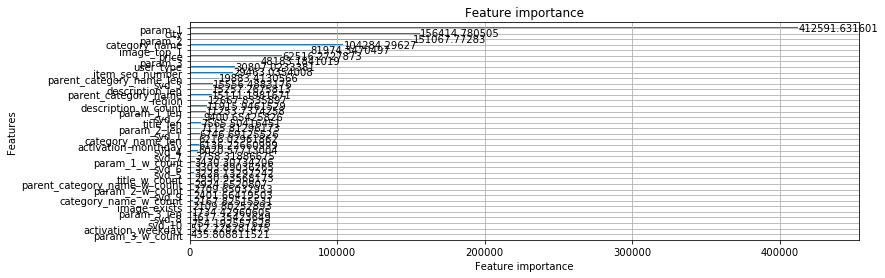

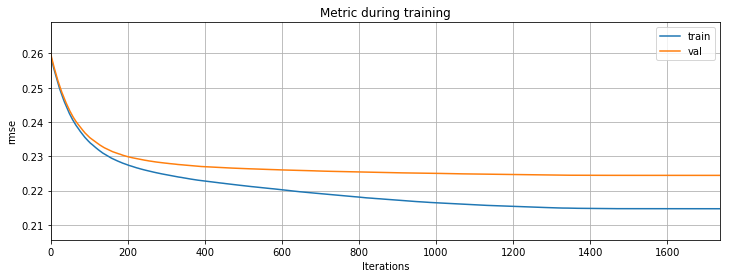

In [58]:
params['learning_rate']=0.01
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.235571 + 0.00021254
[40]	cv_agg's rmse: 0.229878 + 0.000229887
[60]	cv_agg's rmse: 0.228027 + 0.000252535
[80]	cv_agg's rmse: 0.227144 + 0.000265853
[100]	cv_agg's rmse: 0.226589 + 0.000279229
[120]	cv_agg's rmse: 0.226191 + 0.000294869
[140]	cv_agg's rmse: 0.225943 + 0.000306237
[160]	cv_agg's rmse: 0.225714 + 0.000310463
[180]	cv_agg's rmse: 0.225497 + 0.00030635
[200]	cv_agg's rmse: 0.225382 + 0.00031753
[220]	cv_agg's rmse: 0.225223 + 0.000308727
[240]	cv_agg's rmse: 0.225138 + 0.000305329
[260]	cv_agg's rmse: 0.225084 + 0.000294933
[280]	cv_agg's rmse: 0.225065 + 0.000294671
[300]	cv_agg's rmse: 0.225059 + 0.00029288
[320]	cv_agg's rmse: 0.225058 + 0.000292882
[340]	cv_agg's rmse: 0.225056 + 0.000292793
[360]	cv_agg's rmse: 0.22505 + 0.000290974
[380]	cv_agg's rmse: 0.225049 + 0.00029085
[400]	cv_agg's rmse: 0.225049 + 0.000291184
[420]	cv_agg's rmse: 0.225049 + 0.000291185
Best Iteration: 401
[20]	train's rmse: 0.23413	val's rmse: 0.235493
[40]	train's rmse:

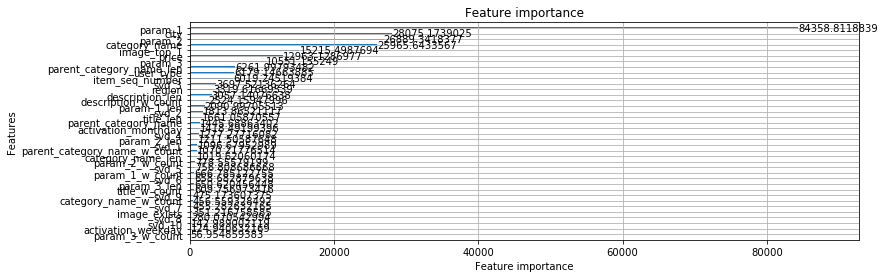

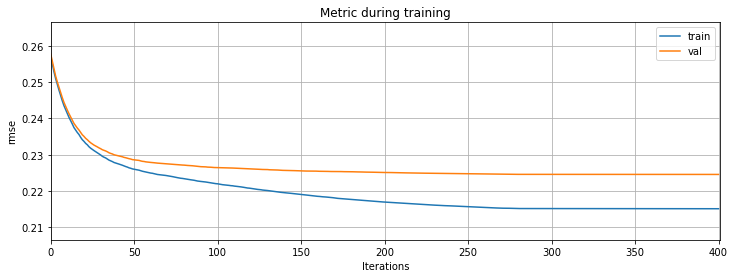

In [55]:
params['learning_rate']=0.05
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.231498 + 0.000242911
[40]	cv_agg's rmse: 0.22793 + 0.000262934
[60]	cv_agg's rmse: 0.226776 + 0.000283213
[80]	cv_agg's rmse: 0.226174 + 0.000302213
[100]	cv_agg's rmse: 0.225781 + 0.000304336
[120]	cv_agg's rmse: 0.225528 + 0.000292279
[140]	cv_agg's rmse: 0.225343 + 0.000298136
[160]	cv_agg's rmse: 0.225205 + 0.000286111
[180]	cv_agg's rmse: 0.225157 + 0.000288436
[200]	cv_agg's rmse: 0.225153 + 0.00028798
[220]	cv_agg's rmse: 0.225151 + 0.000288841
[240]	cv_agg's rmse: 0.225151 + 0.000288897
Best Iteration: 229
[20]	train's rmse: 0.229427	val's rmse: 0.231262
[40]	train's rmse: 0.224728	val's rmse: 0.227753
[60]	train's rmse: 0.222366	val's rmse: 0.226535
[80]	train's rmse: 0.220721	val's rmse: 0.226071
[100]	train's rmse: 0.219131	val's rmse: 0.22556
[120]	train's rmse: 0.217712	val's rmse: 0.225357
[140]	train's rmse: 0.216515	val's rmse: 0.225061
[160]	train's rmse: 0.21567	val's rmse: 0.224883
[180]	train's rmse: 0.215086	val's rmse: 0.224724
[200]	train's 

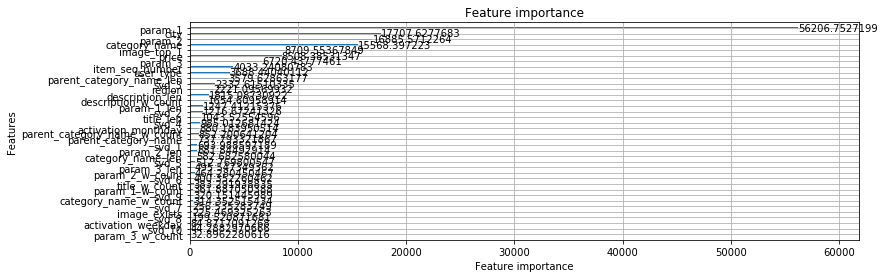

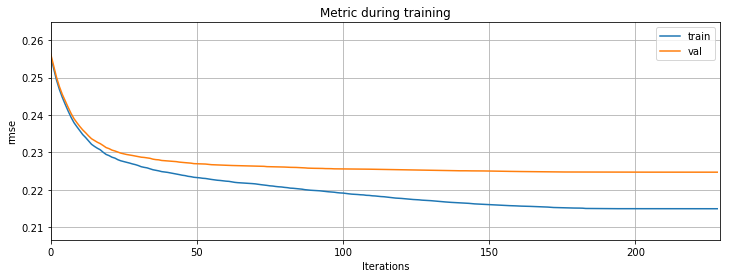

In [56]:
params['learning_rate']=0.08
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.230089 + 0.000219805
[40]	cv_agg's rmse: 0.227315 + 0.000261037
[60]	cv_agg's rmse: 0.226395 + 0.000293812
[80]	cv_agg's rmse: 0.225901 + 0.000300331
[100]	cv_agg's rmse: 0.225609 + 0.000316879
[120]	cv_agg's rmse: 0.225397 + 0.000332785
[140]	cv_agg's rmse: 0.225327 + 0.000319604
[160]	cv_agg's rmse: 0.225296 + 0.000317545
[180]	cv_agg's rmse: 0.225296 + 0.000317288
[200]	cv_agg's rmse: 0.225292 + 0.00031696
[220]	cv_agg's rmse: 0.225292 + 0.00031696
Best Iteration: 198
[20]	train's rmse: 0.227668	val's rmse: 0.229778
[40]	train's rmse: 0.223429	val's rmse: 0.227022
[60]	train's rmse: 0.221038	val's rmse: 0.226035
[80]	train's rmse: 0.219298	val's rmse: 0.22564
[100]	train's rmse: 0.217656	val's rmse: 0.225233
[120]	train's rmse: 0.216271	val's rmse: 0.225063
[140]	train's rmse: 0.215342	val's rmse: 0.224729
[160]	train's rmse: 0.215027	val's rmse: 0.224608
[180]	train's rmse: 0.215007	val's rmse: 0.224602
Model report on trian:
Train RMSE:0.2150
Model report on 

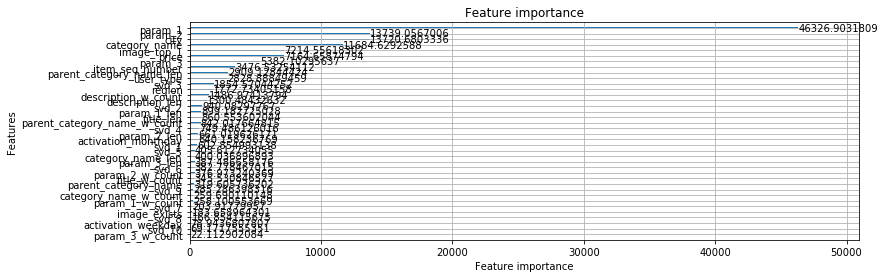

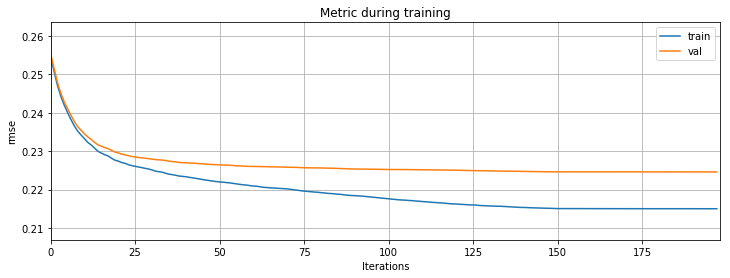

In [57]:
params['learning_rate']=0.1
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [59]:
params['learning_rate']=0.01
params['n_estimators']=1737

# 3 Final model

In [60]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.45,
 'learning_rate': 0.01,
 'max_bin': 511,
 'max_depth': 17,
 'min_child_samples': 30,
 'min_child_weight': 1e-05,
 'min_split_gain': 0.18,
 'n_estimators': 1737,
 'n_jobs': -1,
 'num_leaves': 149,
 'objective': 'regression',
 'random_state': 9,
 'reg_alpha': 0.01,
 'reg_lambda': 0.001,
 'subsample': 1.0000000000000002,
 'subsample_freq': 1}

In [61]:
lgbr_opt=lgb.LGBMRegressor(**params)

In [62]:
lgbr_opt.fit(train_X,train_y,feature_name=list(train_X.columns),categorical_feature=cat_vars)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.45, learning_rate=0.01,
       max_bin=511, max_depth=17, min_child_samples=30,
       min_child_weight=1e-05, min_split_gain=0.18, n_estimators=1737,
       n_jobs=-1, num_leaves=149, objective='regression', random_state=9,
       reg_alpha=0.01, reg_lambda=0.001, silent=True,
       subsample=1.0000000000000002, subsample_for_bin=50000,
       subsample_freq=1)

In [63]:
pred_test=lgbr_opt.predict(test_X)

In [65]:
pred_test[pred_test > 1] = 1
pred_test[pred_test < 0] = 0
sub_df = pd.DataFrame({"item_id": test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv(data_dirs['pred_result'], index=False)

In [66]:
sub_df.head()

,item_id,deal_probability
0,6544e41a8817,0.076535
1,65b9484d670f,0.097557
2,8bab230b2ecd,0.164042
3,8e348601fefc,0.031219
4,8bd2fe400b89,0.253403


In [69]:
public_score=0.2286

In [67]:
feat_imp

activation_hour                     0
param_3_w_count                    45
param_2_w_count                   152
category_name_w_count             153
param_3_len                       153
parent_category_name_w_count      165
parent_category_name_len          241
param_1_w_count                   249
image_exists                      262
param_2_len                       403
category_name_len                 522
activation_weekday                583
parent_category_name              729
svd_10                            759
param_1_len                       900
user_type                        1113
title_w_count                    1400
svd_6                            1808
svd_9                            1869
svd_4                            2017
svd_8                            2069
svd_2                            2614
svd_7                            2857
svd_5                            3195
svd_1                            3804
description_w_count              3831
region      